# Imaging High Redshift Quasars
GOAL: do a SDSS query and look at images of high redshift quasars in MegaPipe images

> Chris Willott: the idea there is to use astroquery to select a sample of quasars from the SDSS catalog server with some particular properties and then cross-match that list against CFHT MegaPipe imaging in the i filter and get images for all the matched quasars. So if you can get a query to SDSS working first and then do the cross-match of a few quasar positions to get some with CFHT imaging we can fine tune the exact criteria and “science goal” later on. There is a CAS jobs AGN/quasar catalog that can be queried described at https://www.sdss.org/dr14/data_access/value-added-catalogs/?vac_id=optical-emission-line-properties-and-black-hole-mass-estimates-for-spiders-dr14-agn

SPectroscopic IDentfication of ERosita Sources (SPIDERS) https://www.sdss.org/surveys/eboss/#spiders
 
his page explains how to access DR14 data, and provides links to various data access tools: https://www.sdss.org/dr14/data_access/

In this notebook, we will image quasars with a high redshift. To find the quasars, we will query SDSS Value Addded Catalog (VAC) that contains a list of quasars and their properties, then select some that fit our requirements. Then we will query CADC data for the 

TODO: Ask about this: https://www.sdss.org/dr15/algorithms/qso_catalog/

To fetch data, we will use the CADC package of astroquery, which queries data provided by the [Canadian Astronomical Data Centre](http://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca ). This tutorial will end-to-end from querying to displaying an image.

## Table of Contents
* [1. Introduction](#Introduction)
* [2. Setup](#Setup)
* [3. Querying](#Querying)
* [4. Fetching Data](#Fetching-Data)
* [5. Ploting Results](#Ploting-Results)

## Introduction
Info about
* SDSS
* MegaPipe
* Quasars


## Setup
This tutorial will go through some of the basic functionalities of the CADC astroquery package. The CADC module can be installed using the command:

```
pip install --pre astroquery
```

(The `--pre` tag installs the pre-release version which we need because the CADC package is not in the latest release.) Alternatively, you can clone and install from the source:

```
# If you have a github account:
git clone git@github.com:astropy/astroquery.git
# If you do not:
git clone https://github.com/astropy/astroquery.git
cd astroquery
python setup.py install
```
Note that these commands can also be done in a jupyter notebook by either declaring the code cell a bash cell by pasting `%%bash` at the top of the cell, or preceding each line with a `!`.
More information about astroquery can be found at the [astroquery github repository](https://github.com/astropy/astroquery).

Now, onto the tutorial!

## Querying

### Find suitable target
For this tutorial, we want to look at high redshift quasars. We will use the SDSS survey data to collect suitable quasars


To find a suitable quasar, we can look at the [SPIDERS DR14 AGN
VAC](https://www.sdss.org/dr14/data_access/value-added-catalogs/?vac_id=optical-emission-line-properties-and-black-hole-mass-estimates-for-spiders-dr14-agn). The corresponding database is called `spiders_quasar`, from the decriptions given from the[table schema](https://skyserver.sdss.org/dr14/en/help/browser/browser.aspx#&&history=description+spiders_quasar+U) we will grab the `name`, `RA`, `DEC`, `MJD`, `redshift`, `CLASS_BEST`, `CONF_BEST` and `DR14_ZWARNING` columns where `redshift` is greater than 1.5.

We can actually query and collect the data in one step using the skyserver api. There is a SQL search service which allows us to pass in an SQL query and it returns the results in the specified format. From the [API docs](https://skyserver.sdss.org/dr15/en/help/docs/api.aspx#search)...

>3. SQL Search
GET or POST /sqlSearch

>|Parameters | Expected Values |
|---|---|
|cmd |SQL query |
|format |output file format. E.g. csv,html,xml,votable,json,fits,mydb |
|limit |maximum number of rows retrieved. If set to 0, then all rows will be retrieved. |
|syntax |If set to Syntax, then only a syntax check is performed on the SQL query and no result table is returned. |

>Example:
http://skyserver.sdss.org/dr15/SkyServerWS/SearchTools/SqlSearch?cmd=select%20top%2010%20ra,dec%20from%20Frame&format=csv


In [79]:
from astropy.table import Table
import urllib 

# Define the query
query = """SELECT name, RA, DEC, MJD, redshift, CLASS_BEST, CONF_BEST, DR14_ZWARNING 
FROM spiders_quasar
WHERE redshift > 2.2 AND CLASS_BEST='QSO' AND DR14_ZWARNING=0"""

# Build the request
base_url = 'http://skyserver.sdss.org/dr15/SkyServerWS/SearchTools/SqlSearch'
parameters = {'cmd': query, 'format': 'fits'} 
url_params = urllib.parse.urlencode(parameters)
data_url = '{}?{}'.format(base_url, url_params)

# Grab the data from the url and convert to a pandas dataframe
qso_table = Table.read(data_url, format='fits')
qso_data = qso_table.to_pandas()
qso_data

# TODO: Delete?
# # Need to get the fits 1st exetention, file (stream), then do our query
# from astropy.table import Table

# #fname = 'data/spiders_quasar_bhmass-DR14.fits' # If url takes too long
# url = 'https://data.sdss.org/sas/dr14/eboss/spiders/analysis/spiders_quasar_bhmass-DR14.fits'
# important_cols = ['xray_detection', 'name', 'RA', 'DEC', 'plate', 'redshift']


# # Grab the data from the url and convert to a pandas dataframe
# qso_table = Table.read(url, format='fits')
# qso_data = qso_table.to_pandas()

# # Filter and sort the data on redshift value
# high_redshift_qso_data = qso_data[qso_data['redshift']  > 1.5].sort_values(by=['redshift'], ascending=False)
# high_redshift_qso_data[important_cols]


,name,RA,DEC,MJD,redshift,CLASS_BEST,CONF_BEST,DR14_ZWARNING
0,b'2RXS J001312.2+140135',3.301030,14.026480,56191,2.211000,b'QSO',3,0
1,b'2RXS J005236.6+014100',13.152840,1.683500,55584,2.301000,b'QSO',3,0
2,b'2RXS J012642.9+255901',21.679090,25.983660,57062,2.368770,b'QSO',3,0
3,b'2RXS J085218.2+473455',133.076040,47.582140,55968,2.415342,b'QSO',3,0
4,b'2RXS J091547.5+410310',138.947990,41.052780,55947,2.320000,b'QSO',3,0
5,b'2RXS J091729.4+373928',139.372580,37.658000,55946,2.248000,b'QSO',3,0
6,b'2RXS J100516.6+480545',151.319200,48.095890,56366,2.390000,b'QSO',3,0
7,b'2RXS J122824.0+312817',187.100360,31.471600,56364,2.220000,b'QSO',3,0
8,b'2RXS J132016.5+095337',200.069110,9.893880,55987,2.477000,b'QSO',3,0
9,b'2RXS J133148.8+303145',202.953740,30.529290,56362,2.380000,b'QSO',3,0


Now we have a list of suitable quasars! Yay! Now, in order to query the CADC data, we are going to extract the coordinates and search for all `CFHTMEGAPIPE` data collections in those coordinates.

In [80]:
from astropy.coordinates import SkyCoord
#TODO: Ask which one I should be using - coords from name or col value

# name_list = qso_data['name'].values
# coords = [SkyCoord.from_name(str(qso_name), parse=True) for qso_name in name_list]

ra_list = qso_data['RA'].values
dec_list = qso_data['DEC'].values
coords_list = [SkyCoord(ra, dec, frame='icrs', unit='deg') for ra, dec in zip(ra_list, dec_list)]
coords_list


[<SkyCoord (ICRS): (ra, dec) in deg
     (3.30103, 14.02648)>, <SkyCoord (ICRS): (ra, dec) in deg
     (13.15284, 1.6835)>, <SkyCoord (ICRS): (ra, dec) in deg
     (21.67909, 25.98366)>, <SkyCoord (ICRS): (ra, dec) in deg
     (133.07604, 47.58214)>, <SkyCoord (ICRS): (ra, dec) in deg
     (138.94799, 41.05278)>, <SkyCoord (ICRS): (ra, dec) in deg
     (139.37258, 37.658)>, <SkyCoord (ICRS): (ra, dec) in deg
     (151.3192, 48.09589)>, <SkyCoord (ICRS): (ra, dec) in deg
     (187.10036, 31.4716)>, <SkyCoord (ICRS): (ra, dec) in deg
     (200.06911, 9.89388)>, <SkyCoord (ICRS): (ra, dec) in deg
     (202.95374, 30.52929)>, <SkyCoord (ICRS): (ra, dec) in deg
     (204.50932, 42.66799)>, <SkyCoord (ICRS): (ra, dec) in deg
     (206.72227, 40.59386)>, <SkyCoord (ICRS): (ra, dec) in deg
     (212.62527, 13.99505)>, <SkyCoord (ICRS): (ra, dec) in deg
     (212.70485, 46.27886)>, <SkyCoord (ICRS): (ra, dec) in deg
     (217.35145, 46.87933)>, <SkyCoord (ICRS): (ra, dec) in deg
     (218.57156

### Query Method 1: `query_region` function
The simplest way to query data by target name is to use the `query_region` function. It takes a set of coordinates and a collection source and returns all the results that intersect with the coordinates from the given collection source. After querying, we can further filter down the results using boolean masks on the data. In order to filter the data, we need to see which columns are in the results, and also what data type they are. So lets first do the query and then print the resulting columns and their descriptions.

In [81]:
from astropy.table import vstack
from astroquery.cadc import Cadc
cadc = Cadc()

#results_list = [cadc.query_region(coords, collection='CFHTMEGAPIPE') for coords in coords_from_name]
# coords_results_list = list(zip(coords_from_name, results_list))
# print(coords_results_list)

results_list = []
name_list = qso_data['name'].values
for target_name, coords in zip(name_list, coords_list): # TODO: try with coords from field too
    results = cadc.query_region(coords, radius=0.01, collection='CFHTMEGAPIPE')
    if len(results):
        # We add target coordinates as columns to later make cutout process easier
        # TODO: Make a new numpy table instead?
        results['qso_target_name'] = target_name
        results['qso_target_ra'] = coords.ra
        results['qso_target_dec'] = coords.dec
        results_list.append(results)
    
# Maybe add a column to the table with target coordinates?? For better imaging???
# ^ I like adding the column idea > better for when we stack the table
# Could also do a dict with target_name, target_coords, results_table??
#results = vstack(results_list)
#results.show_in_notebook()

results = vstack(results_list)  


Looking through the columns, we want results that have the i filter (https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/en/megapipe/docs/filt.html). So either I.MP9701, I.MP9702, or I.MP9703 for `energy_bandpssName`, also `dataProductType` of type 'image'. Once we filter the results, we will display a subset of the columns (since there are so many!) using the astropy table `show_in_notebook` method.


In [82]:
# Construct the filter
results_filter = ([energy_bandpass_name.startswith('i.') for energy_bandpass_name in 
                   results['energy_bandpassName']]) &\
                 (results['dataProductType'] == 'image')

# Apply the filter to the results
filtered_results = results[results_filter]

print('Number of results pre-filter: {}'.format(len(results)))
print('Number of results post-filter: {}'.format(len(filtered_results)))

columns_subset = ['productID', 'collection', 'observationID', 'energy_bandpassName', \
                  'target_name', 'qso_target_name', 'qso_target_ra', 'qso_target_dec', \
                   'telescope_name', 'instrument_name', 'dataProductType', 'quality_flag']

filtered_results[columns_subset].show_in_notebook()


Number of results pre-filter: 62
Number of results post-filter: 7


idx,productID,collection,observationID,energy_bandpassName,target_name,qso_target_name,qso_target_ra,qso_target_dec,telescope_name,instrument_name,dataProductType,quality_flag
,,,,,,,deg,deg,,,,
0,MegaPipe.210.262.I.MP9702,CFHTMEGAPIPE,MegaPipe.210.262,i.MP9702,M0913,2RXS J091547.5+410310,138.94799,41.05278,CFHT 3.6m,MegaPrime,image,
1,G025.138.432+40.928.I3,CFHTMEGAPIPE,G025.138.432+40.928,i.MP9703,M0913,2RXS J091547.5+410310,138.94799,41.05278,CFHT 3.6m,MegaPrime,image,
2,G018.186.615+31.342.I,CFHTMEGAPIPE,G018.186.615+31.342,i.MP9701,NGC 4414,2RXS J122824.0+312817,187.10036,31.4716,CFHT 3.6m,MegaPrime,image,
3,G018.186.660+31.865.I,CFHTMEGAPIPE,G018.186.660+31.865,i.MP9701,NGC 4414 OFF,2RXS J122824.0+312817,187.10036,31.4716,CFHT 3.6m,MegaPrime,image,
4,MegaPipe.319.243.I.MP9701,CFHTMEGAPIPE,MegaPipe.319.243,i.MP9701,F08746_1,2RXS J122824.0+312817,187.10036,31.4716,CFHT 3.6m,MegaPrime,image,
5,MegaPipe.319.243.I.MP9702,CFHTMEGAPIPE,MegaPipe.319.243,i.MP9702,F08746_1,2RXS J122824.0+312817,187.10036,31.4716,CFHT 3.6m,MegaPrime,image,
6,MegaPipe.413.208.I.MP9701,CFHTMEGAPIPE,MegaPipe.413.208,i.MP9701,CPAPIR-307,2RXS J141030.0+135942,212.62527,13.99505,CFHT 3.6m,MegaPrime,image,


### Query Method 2: ADQL
The second method is to bundle the query and filtering in one using Astronomical Data Query Language, or ADQL. In this case, we will do both the querying and the filtering in one step.

In [83]:
# HMMM seems like you might have a problem with adding a column with the qso target name this method...

# from astroquery.cadc import Cadc
# cadc = Cadc()
# intersection = []
# coords = coords_from_ra_dec_fields

# intersection_list = ["( INTERSECTS( CIRCLE('ICRS', {ra}, {dec}, {radius}), Plane.position_bounds ) = 1 )"\
#                 .format(ra=coord.ra.deg, dec=coord.dec.deg, radius=0.01) for coord in coords]
# intersection_conditional = ' OR '.join(intersection_list)
# query_vars = { 'filter_name': 'i.', 'collection': 'CFHTMEGAPIPE', 'intersection': intersection_conditional}

# query = '''SELECT *
# FROM caom2.Plane AS Plane 
# JOIN caom2.Observation AS Observation ON Plane.obsID = Observation.obsID 
# WHERE ( ( Observation.collection = '{collection}' )
# AND ( Plane.energy_bandpassName LIKE '{filter_name}%' )
# AND ( Plane.dataProductType = 'image')
# AND ( {intersection}) )'''.format(**query_vars)

# job = cadc.run_query(query, 'sync');
# results = job.get_results()
# results.show_in_notebook()

# TODO: There might be a difference between async and sync queries returning different results

Notice how we have the same number of results using both the two methods? Pretty  neat :)

## Fetching Data
Now let's choose two images, find a suitable cutout, download them, and display them. We will use the `get_data_urls` function to actually access the data.

In [84]:
urls = cadc.get_data_urls(filtered_results)
filtered_results['url'] = urls

The stucture of the url's can be broken into a few parts. Take `https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/data/pub/GEMINI/N20050108S0186.fits.gz?RUNID=tv7rbo39ibkh7726` as an example...
- `https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/data/pub/`: This is the service url. The 'data/pub' ending accesses all public files. For files the requires authorization, there will be a redirect to 'data/auth' which require authorization
- `GEMINI`: This is the archive name.
- `N20050108S0186.fits.gz`: This is the file name.
- `RUNID=tv7rbo39ibkh7726`: TODO: Get a good definition for this!! These are additional query parameters. I don't exactly know what this means!

The urls give access to the actual data, so now we can fetch the file, get data to calculate a cutout, open it with the astropy fits module, and display an image!


### Retriving Data with Requests
With the cutout values, we can now download the data. There are many different methods to perform a cutout, but today we will add the cutout string to the parameter in the request. More information about requesting CADC data can be found [in the documentation](http://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/en/doc/data/).


In [100]:
import re
from astropy.wcs import WCS
from astropy.io import fits
def get_target_image_data_from_result(result, radius=0.01, ext=0):
    
    '''Returns the image data and wcs coordinate data of a fits file at the 
    given extension'''
    
    uri = 'ad:'+ re.findall("https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/data/pub/(.+)\?RUNID=", result['url'])[0]
    ra = result['qso_target_ra']
    dec = result['qso_target_dec']
    cutout_region_string = 'Circle ICRS {ra} {dec} {radius}'.format(ra=ra, dec=dec, radius=radius)
    params_dict = {'uri': uri, 'cutout': cutout_region_string}
    
    base_url = 'https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/caom2ops/cutout'
    
    url_params = urllib.parse.urlencode(params_dict)
    data_url = '{}?{}'.format(base_url, url_params)
    print(data_url)
    try:
        with fits.open(data_url, ignore_missing_end=True) as hdulist:
            hdulist.info()
            w = WCS(hdulist[ext].header)
            image_data = hdulist[ext].data
        return image_data, w    
    except:
        print('Error: Problem with {}'.format(data_url))
        return False, False

data_list = [(*get_target_image_data_from_result(result), 
              result['qso_target_name'], result['qso_target_ra'], result['qso_target_dec']) 
             for result in filtered_results]
# TODO: Make this a dict? 


https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/caom2ops/cutout?uri=ad%3ACFHTSG%2FMegaPipe.210.262.I.MP9702.fits&cutout=Circle+ICRS+138.94799+41.05278+0.01
Filename: /home/badune/.astropy/cache/download/py3/f64513feea83811469c5e0223f179525
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      56   (391, 390)   float32   


https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/caom2ops/cutout?uri=ad%3ACFHTSG%2FG025.138.432%2B40.928.I3.fits&cutout=Circle+ICRS+138.94799+41.05278+0.01
Filename: /home/badune/.astropy/cache/download/py3/c678bffb34a4db8c3e2a29fa4001b04b
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      76   (392, 392)   float32   


https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/caom2ops/cutout?uri=ad%3ACFHTSG%2FG018.186.615%2B31.342.I.fits&cutout=Circle+ICRS+187.10036+31.4716+0.01
Filename: /home/badune/.astropy/cache/download/py3/22684f144e4e9a99eeb2e58decd33db1
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      73   (391, 391)   float32   


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/caom2ops/cutout?uri=ad%3ACFHTSG%2FG018.186.660%2B31.865.I.fits&cutout=Circle+ICRS+187.10036+31.4716+0.01
Filename: /home/badune/.astropy/cache/download/py3/de5d08a6f30371063f5428ffacbbd4a3
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      73   (391, 391)   float32   
https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/caom2ops/cutout?uri=ad%3ACFHTSG%2FMegaPipe.319.243.I.MP9701.fits&cutout=Circle+ICRS+187.10036+31.4716+0.01
Filename: /home/badune/.astropy/cache/download/py3/fb0843d72ccf5f007b3054ddab930c7b
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      67   (390, 390)   float32   


https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/caom2ops/cutout?uri=ad%3ACFHTSG%2FMegaPipe.319.243.I.MP9702.fits&cutout=Circle+ICRS+187.10036+31.4716+0.01
Filename: /home/badune/.astropy/cache/download/py3/aad965251952e3248008eef7635dc62f
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      57   (390, 390)   float32   


https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/caom2ops/cutout?uri=ad%3ACFHTSG%2FMegaPipe.413.208.I.MP9701.fits&cutout=Circle+ICRS+212.62527+13.99505+0.01
Filename: /home/badune/.astropy/cache/download/py3/18fee186f023ad13024278633a1babc3
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      56   (389, 390)   float32   


## Ploting Results

Now that we have the image data and the coordinate data of all our cutouts, we can begin to plot the data!

In [101]:
def print_image_list_stats(data_list):
    for idx, (image_data, w, name) in enumerate(data_list):
        print("IMAGE {} STATS".format(idx))
        nonzero = np.count_nonzero(image_data)
        total = image_data.size
        print('Percent Nonzero: {}'.format(nonzero/total))
        stats = {'min': np.nanmin(image_data), 'max': np.nanmax(image_data), 
                 'mean': np.nanmean(image_data), 'std': np.nanstd(image_data)}
        print('Min: {min} \nMax: {max} \nMean: {mean}\nStdev: {std}'.format(**stats))
    
#print_image_list_stats(data_list)

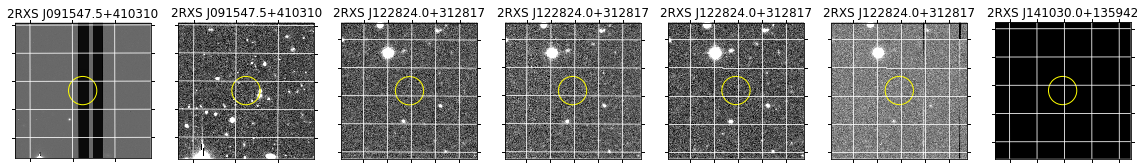

In [102]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from astropy.visualization import (LinearStretch, ImageNormalize, PercentileInterval, 
                                   MinMaxInterval, ZScaleInterval)

np.seterr(divide='ignore', invalid='ignore')
#TODO: Add lables and titles!
#TODO: look and see how to make imshow better
#TODO: Add circles around targets
def plot_image_list(data_list, geo=None):

    if geo is None:
        geo = (1,len(data_list)) #nrows, ncols
        
    fig = plt.figure(figsize=(20,10))
    for idx, (image_data, wcs, qso_target_name, qso_target_ra, qso_target_dec) in enumerate(data_list):
        
        ax = plt.subplot(geo[0], geo[1], idx+1, projection=wcs)

        ax.scatter(qso_target_ra, qso_target_dec, transform=ax.get_transform('icrs'), s=800,
           edgecolor='yellow', facecolor='none')
        image_data_norm = ImageNormalize(image_data, interval=ZScaleInterval(), 
                                         stretch=LinearStretch())
        ax.imshow(image_data, norm=image_data_norm, cmap='gray')
        ax.set_title(qso_target_name)
        
        ax.coords.grid(color='white', ls='solid')
        ra, dec = ax.coords['ra'], ax.coords['dec']
        ra.set_ticklabel_visible(False)
        dec.set_ticklabel_visible(False)
        ra.set_axislabel('')
        dec.set_axislabel('')

# Should I split up into groups of objects we are trying to image???
#plot_image_list(data_list, geo=(4, 5))
plot_image_list(data_list)

ValueError: too many values to unpack (expected 3)

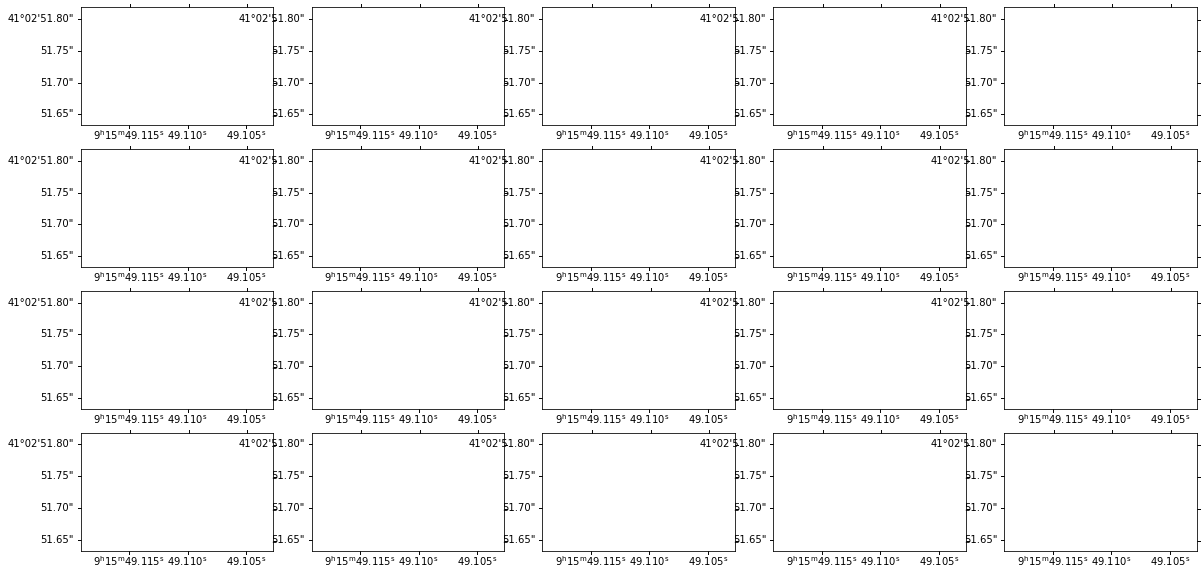

In [93]:
def plot_image_list_same_axes(data_list, geo=None): # Should only really do this for same qso_target_name
    if geo is None:
        geo = (1, len(data_list)) #nrows, ncols
        
    wcs_trans = data_list[1][1]   
    
    fig, ax_list = plt.subplots(geo[0], geo[1], figsize=(20,10), sharex=True, sharey=True, 
                                subplot_kw=dict(projection=wcs_trans))
    flat_ax_list = list(np.array(ax_list).flat)

    
    for ax, (image_data, wcs, qso_target_name) in zip(flat_ax_list, data_list):
        image_data_norm = ImageNormalize(image_data, interval=ZScaleInterval(), 
                                         stretch=LinearStretch())
        ax.imshow(image_data, transform=ax.get_transform(wcs),
                  cmap='gray')
        ax.set_title(qso_target_name)
        ax.coords.grid(color='white', ls='solid')
        ra, dec = ax.coords['ra'], ax.coords['dec']
        ra.set_ticklabel_position('lb')
        dec.set_ticklabel_position('lb')
        
    plt.xlabel('Right Ascension')
    plt.ylabel('Declination')

plot_image_list_same_axes(data_list, geo=(4,5))